# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 11


## Rui Fang $\quad$ Collaborator: Yijun Shen

**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Monday, April 23rd, 2018 at 11:59pm

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## The AM207 Cambridge Nursery

A plant nursery in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to create an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each (the desired effect). 

Out of 197 initial cross-breedings, the nursery obtained the following distribution over the four types of child plants: 
$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$
where $y_i$ represents the number of child plants that are of type $i$.

The nursery then consulted a famed Harvard plant geneticist, who informed them that the probability of obtaining each type of child plant in any single breeding experiment is as follows:
$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}.$$
Unfortunately, the geneticist did not specify the quantity $\theta$.

Clearly, the nursery is interested in understanding how many cross-breeding they must perform, on average, in order to obtain a certain number of child plants with the exotic blue rings. To do this they must be able to compute $\theta$. 

The owners of the nursery, being top students in AM207, decided to model the experiment in hopes of discovering $\theta$ using the results from their 197 initial experiments. 

They chose to model the observed data using a multinomial model and thus calculated the likelihood to be:
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$

Being good Bayesians, they also imposed a prior on $\theta$, $\rm{Beta}(a, b)$.

Thus, the posterior is:
$$ p(\theta \vert  Y) = \left( 2+\theta \right)^{y_1} (1-\theta)^{y_2+y_3} \, \theta^{
y_4} \, \theta^{a-1} \, (1-\theta)^{b-1}. $$

If the nursery owners are able to sample from the posterior, they would be able to understand the distribution of $\theta$ and make appropriate estimates.

## Problem 1. Sampling using data augmentation

Realizing that it would be difficult to sample from the posterior directly and after being repeatedly frustrated by attempts of Metropolis-Hastings and Gibbs sampling for this model, the nursery owners decided to augment their model and hopefully obtain a friendlier looking distribution that allows for easy sampling.

They augment the data with a new variable $z$ such that:
$$z + (y_1 - z) = y_1.$$
That is, using $z$, we are breaking $y_1$, the number of type I child plants, into two subtypes. Let the probability of obtaining the two subtype be $1/2$ and $\theta/4$, respectively. Now, we can interpret $y_1$ to be the total number of trials in a binomial trial. Thus, the new likelihood can be written as
$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$


Derive the joint posterior $p(\theta, z  \vert  y)$ and sample from it using Gibbs sampling.

Visualize the distribution of theta and, from this distribution, estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

***

### *Solution*

The joint posterior 
\begin{align}
p(\theta, z  \vert  y) 
&\propto p(y, z  \vert  \theta) p(\theta) \\
&\propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4} \theta^{a-1} (1-\theta)^{b-1}.
\end{align}

From it we can derive the conditionals 

\begin{align}
p(\theta \vert  z, y) \propto \theta^{z+y_4+a-1} (1-\theta)^{y_2 + y_3 + b-1} 
&\Rightarrow 
p(\theta \vert  z, y) = \text{Beta}(\theta \vert z+y_4+a, y_2 + y_3 + b), \\
p(z \vert  \theta, y) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z} 
&\Rightarrow 
p(z \vert  \theta, y) = \text{Binomial}\left(y_1, \frac{\theta}{2+\theta}\right). 
\end{align}

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from scipy.stats import binom

sns.set()

In [2]:
# Gibbs sampler (adapted from lacture note)
def gibbs(xgiveny_sample, ygivenx_sample, N, start = [0,0]):
    x = start[0]
    y = start[1]
    samples = np.zeros((N+1, 2))
    samples[0, 0] = x
    samples[0, 1] = y
    
    for i in range(1, N, 2):
        x = xgiveny_sample(y)
        samples[i, 0] = x
        samples[i, 1] = y
        
        y = ygivenx_sample(x)
        samples[i+1, 0] = x
        samples[i+1, 1] = y
        
    return samples

# Observed data 
y1, y2, y3, y4 = 125, 18, 20, 34 

# Prior parameters on theta 
a, b = 2, 2 

# Conditional distributions 
def theta_cond(z):
    return beta.rvs(z+y4+a, y2+y3+b)

def z_cond(theta):
    return binom.rvs(y1, theta/(2+theta))

# Perform Gibbs sampling
out = gibbs(theta_cond, z_cond, 100000)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

<IPython.core.display.Javascript object>


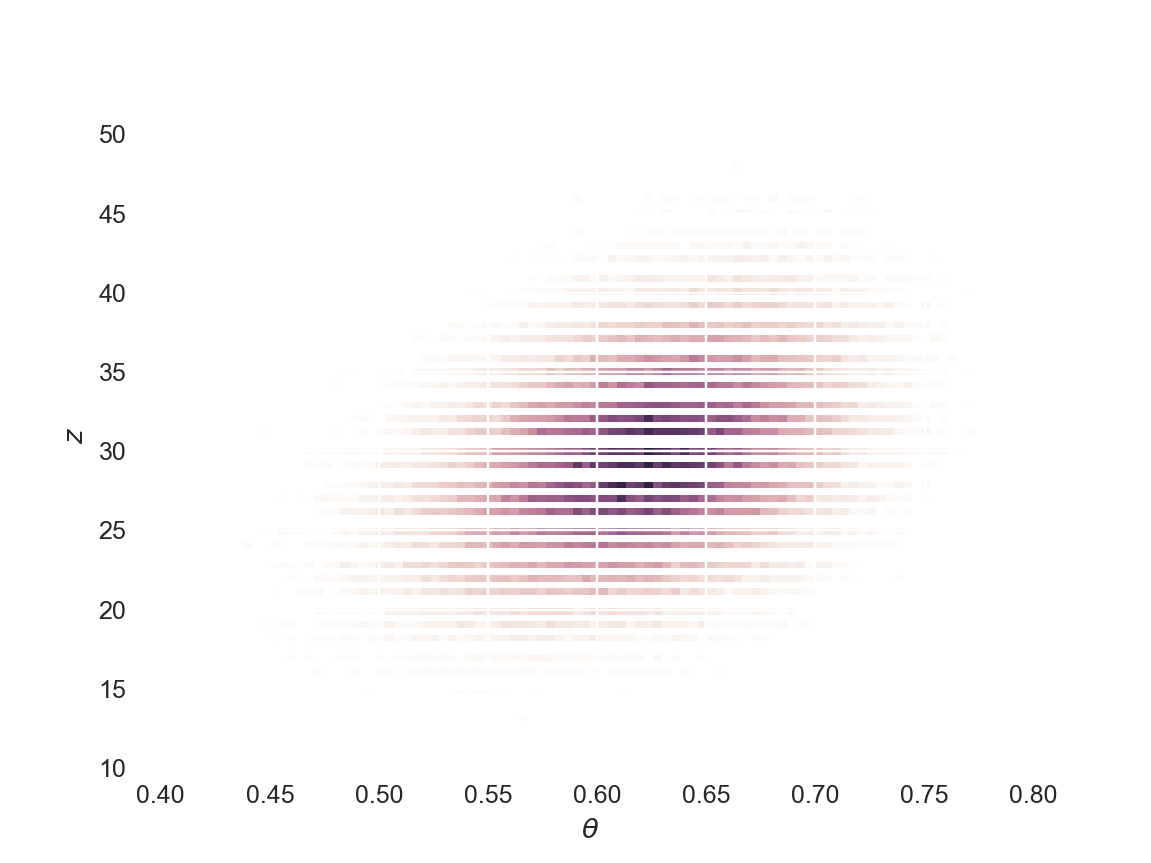

In [3]:
# Plot joint distribution 
plt.figure()
plt.hist2d(out[10000:,0],out[10000:,1], normed=True, bins=100, cmap=cmap)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$z$')
plt.show()

<IPython.core.display.Javascript object>


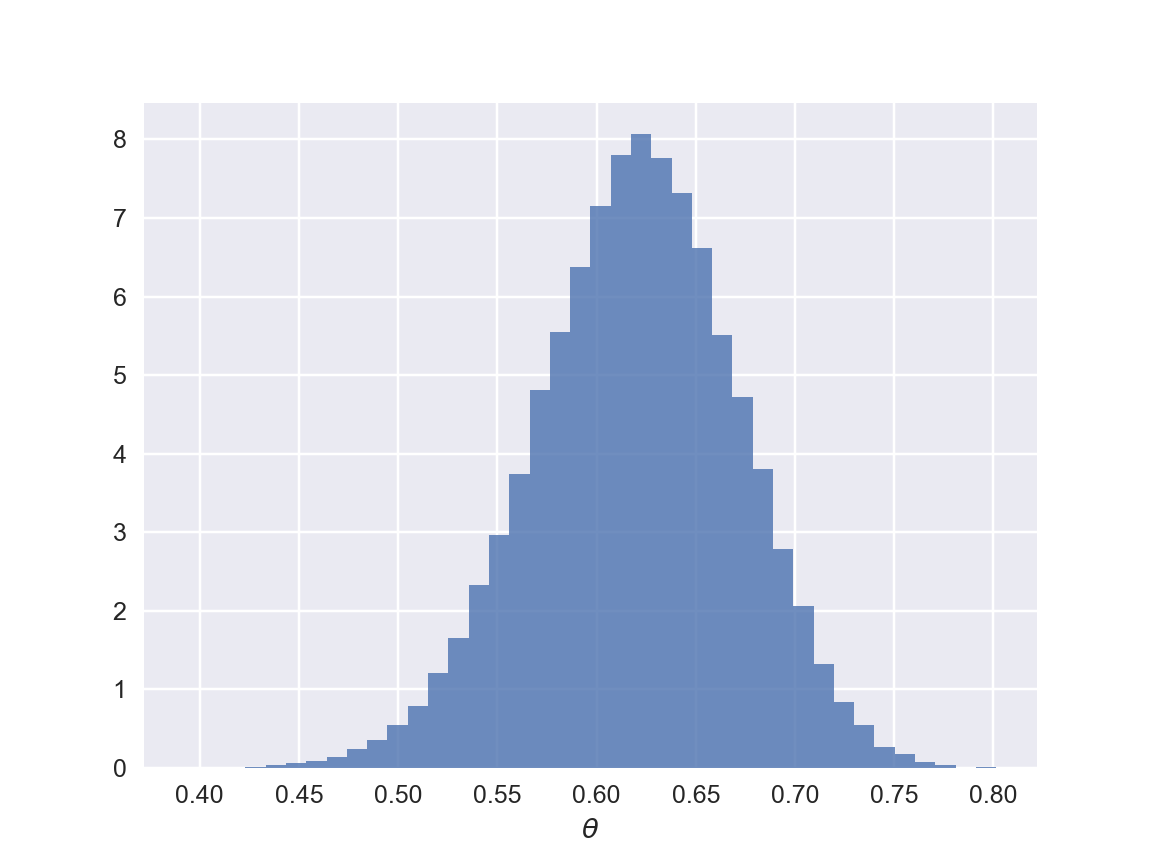

In [4]:
# Plot theta distribution 
plt.figure()
plt.hist(out[10000:,0], 40, density=True, alpha=0.8)
plt.xlabel(r'$\theta$')
plt.show()

In [5]:
# Mean estimate of theta 
mean_theta = np.mean(out[10000:,0])

print(mean_theta/4)

0.15496486653458336


Therefore, the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment is **0.155**.

***

## Problem 2. Finding the MLE using Expectation Maximization

Treat the augmented model as a latent variable model. 

### Part A. 

Write down an expression (up to unimportant constants - you must decide what unimportant means) for each of the following:

(1) the observed data log likelihood

(2) the complete(full) data log likelihood

**Hint:** You should already have the observed data likelihood and the complete data likelihood from Problem 1, you just need to take their logs for this problem.

(3) the Auxilary function, $Q(\theta, \theta^{(t-1)})$, or the expected complete(full) data log likelihood, defined by
$$Q(\theta, \theta^{(t-1)}) = \mathbb{E}_{Z  \vert  Y=y, \Theta = \theta^{t-1}}[\text{the complete data log likelihood}]$$

In other words $Z  \vert  Y=y, \Theta = \theta^{t-1}$ is $q(z, \theta_{old})$ from lecture at the end of the E-step and $Q$ is the z-posterior expectation (at $\theta_{old}$) of the full data log likelihood, which is the ELBO minus the entropy of $q$ (which being evaluated at $\theta_{old}$ is not dependent on $\theta$ and thus irrelevant for maximization).

***

### *Solution*

(1) the observed data log likelihood

\begin{align}
    \log p(y \vert \theta) 
    &= \log \left( C (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}\right) \\
    &= \log C + y_1 \log(2+\theta) + (y_2+y_3) \log(1-\theta) + y_4 \log \theta
\end{align}
where $C$ is normalization constant. 

(2) the complete(full) data log likelihood
\begin{align}
    \log p(y, z \vert \theta) 
    &= \log \left( C \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4} \right) \\
    &= \log C + \log \binom{y_{1}}{z} + (y_1-z) \log \left (\frac{1}{2} \right ) + z \log \left(\frac{\theta}{4} \right ) + (y_2+y_3) \log(1-\theta) + y_4 \log \theta
\end{align}
where $C$ is normalization constant. 

(3) the Auxilary function, $Q(\theta, \theta^{(t-1)})$, or the expected complete(full) data log likelihood
\begin{align}
Q(\theta, \theta^{(t-1)}) 
&= \mathbb{E}_{Z  \vert  Y=y, \Theta = \theta^{t-1}}[\log p(y, z \vert \theta) ] \\
&= \log C + \mathbb{E} \left[\log \binom{y_{1}}{z} \right] + y_1 \log \left (\frac{1}{2} \right ) - \mathbb{E}[z]\log \left (\frac{1}{2} \right ) + \mathbb{E}[z] \log \left(\frac{\theta}{4} \right ) + (y_2+y_3) \log(1-\theta) + y_4 \log \theta \\
&= \log C + \mathbb{E} \left[\log \binom{y_{1}}{z} \right] + y_1 \log \left (\frac{1}{2} \right ) - \frac{y_1 \theta^{t-1}}{2+\theta^{t-1}} \log \left (\frac{1}{2} \right ) + \frac{y_1 \theta^{t-1}}{2+\theta^{t-1}}  \log \left(\frac{\theta}{4} \right ) + (y_2+y_3) \log(1-\theta) + y_4 \log \theta 
\end{align}

***

### Part B:

We will maximize the likelihood through Expectation Maximization (EM). In order to preform EM, we must iterate through the following steps

- (Expectation) Compute the Auxilary function, $Q(\theta, \theta^{t-1})$ (the expectation of the full data likelihood)
- (Maximization) Compute $\theta^{t} = \text{argmax}_\theta Q(\theta, \theta^{(t-1)})$

Thus, you must compute exact formulae for the following:
1. the Auxilary function, $Q(\theta, \theta^{(t-1)})$, for a given $\theta^{(t-1)}$. That is, compute the expectation of the complete data log likelihood.
2. $\theta^{t}$, by maximizing the Auxilary function $Q(\theta, \theta^{(t-1)})$.

**Hint:** You don't actually need to do any difficult optimization for the M-step. After taking the expectation of the complete data log likelihood in the E-step, match your $Q(\theta, \theta^{(t-1)})$ to the log pdf of a familiar distribution, then use the known formula for the mode of this distribution to optimize $Q(\theta, \theta^{(t-1)})$.

Use these to **estimate the MLE** of $\theta$ using EM (choose your own reasonable criterion for convergence).

***

### *Solution*

We have computed the Auxilary function $Q(\theta, \theta^{(t-1)})$ in Part A. Now to compute $\theta_t$, 

\begin{align}
\theta^{t} 
&= \text{argmax}_\theta Q(\theta, \theta^{(t-1)}) \\
&= \text{argmax}_\theta \left( \frac{y_1 \theta^{t-1}}{2+\theta^{t-1}}  \log (\theta) + (y_2+y_3) \log(1-\theta) + y_4 \log \theta \right) \\
&= \text{argmax}_\theta \log \left( \theta^{p_1} (1-\theta)^{p_2} \right) \\
&= \frac{p_1}{p_1+p_2}
\end{align}
where $p_1=y_4 + \frac{y_1 \theta^{t-1}}{2+\theta^{t-1}} $, $p_2 = y_2 + y_3$. 

In [12]:
# Estimate the MLE of theta using EM 

theta_old = 0. 
while True: 
    
    # E-step 
    z = y1*theta_old / (2+theta_old)
    
    # M-step 
    p1 = y4 + z
    p2 = y2 + y3
    theta_new = p1 / (p1+p2)
    
    # Print results 
    print('z=%s  theta=%.6f' % (int(z), theta_new))
    
    # Check for convergence 
    if abs(theta_new - theta_old) < 1e-6:
        break 
    
    theta_old = theta_new 

z=0  theta=0.472222
z=23  theta=0.603656
z=28  theta=0.623692
z=29  theta=0.626405
z=29  theta=0.626766
z=29  theta=0.626814
z=29  theta=0.626821
z=29  theta=0.626821


The MLE estimate of $\theta$ using EM is **0.627**.

***